# Import Dependencies

In [1]:
import tensorflow as tf
import cv2
import os
import gdown
import imageio
from typing import List
import matplotlib.pyplot as plt

# Load Data

In [3]:
data_url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(data_url, output, quiet=False)
gdown.extractall(output)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=d17845f1-d106-4c97-8823-0cce896387e6
To: d:\Lip_Read_App\data.zip
100%|██████████| 423M/423M [03:22<00:00, 2.09MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [2]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frame = frame[190:236,80:220,:]
        frames.append(frame)
    
    cap.release()
    #standerdize images
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast(frames-mean,tf.float32)/std

In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token='')

In [6]:
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [7]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [8]:
encoding = num_to_char([14,  9,  3, 11])

In [9]:
[x.decode('utf-8') for x in encoding.numpy()]

['n', 'i', 'c', 'k']

In [10]:
def load_alignments(path:str) -> List[str]:
    tokens = []
    with open(path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        line = line.split()
        if not line[2] == 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),-1))[1:]

In [11]:
load_alignments('D:\\Lip_Read_App\\data\\alignments\\s1\\swwc6p.align')

<tf.Tensor: shape=(27,), dtype=int64, numpy=
array([19,  5, 20, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39,  3, 39,
       19,  9, 24, 39, 16, 12,  5,  1, 19,  5], dtype=int64)>

In [12]:
os.path.splitext(os.path.basename('D:\\Lip_Read_App\\data\\alignments\\s1\\swwc6p.align'))[0]

'swwc6p'

In [13]:
test_path = 'D:\\Lip_Read_App\\data\\s1\\bbas2p.mpg'

In [14]:
def load_data(path:str):
    path = bytes.decode(path.numpy())
    file_name = os.path.splitext(os.path.basename(path))[0]
    frames = load_video(os.path.join('data','s1',f'{file_name}.mpg'))
    aligns = load_alignments(os.path.join('data','alignments','s1',f'{file_name}.align'))

    return frames, aligns

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [16]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 19, 39, 20, 23, 15,
       39, 16, 12,  5,  1, 19,  5], dtype=int64)>

In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at s two please'>

In [18]:
frames.shape

TensorShape([75, 46, 140, 1])

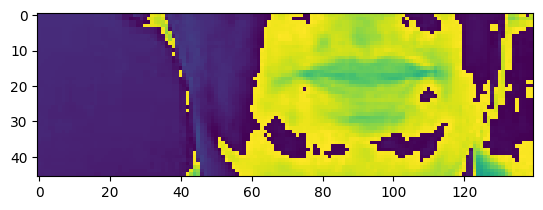

In [19]:
plt.imshow(frames[20])

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipelne

In [21]:
data_url = os.path.join('data','s1','*.mpg')
data = tf.data.Dataset.list_files(data_url)
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [22]:
frames, alignements = data.as_numpy_iterator().next()

In [23]:
frames.shape

(2, 75, 46, 140, 1)

In [24]:
alignements.shape

(2, 40)

In [ ]:
imageio.mimsave('animation.gif', frames[0], duration = 200/50)

In [26]:
train = data.take(450)
test = data.skip(450)

# Build The Deep Neural Network

In [27]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [29]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

# Training the Model

In [30]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [31]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [32]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [35]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=300, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# Make Predictions